
# DATASET and DATALOADER
Code for processing data samples can become messy and hard to maintain; ideally, we want our dataset code to be separated from the model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your custom data.

<font color="green">Dataset:</font>

Dataset is a PyTorch class that stores data samples and their corresponding labels.
It's essentially a representation of raw data without any processing.
It can be customized to fit the specific needs of your dataset by implementing the methods getitem() and len().
A common example is the subclass torch.utils.data.Dataset that defines a dataset like FashionMNIST or CIFAR-10.

<font color="green">Dataloader:</font>

DataLoader is a PyTorch class that wraps a Dataset and makes it iterable.
It provides additional functionalities such as data batching, random sampling, and parallel data loading.
It simplifies access to data samples during model training.
It can be configured with parameters like batch_size, shuffle, num_workers, etc., to customize the data loading behavior.
Essentially, DataLoader "packages" Dataset data into manageable mini-batches for model training.
Here's an example of loading the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando's article images consisting of 60,000 training examples and 10,000 test examples. Each example includes a grayscale image of size 28×28 and an associated label from one of the 10 classes.

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
print(f"Training Data info: {training_data}")
print(f"Test Data info: {test_data}")


Training Data info: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test Data info: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Specifically:

Root: It is the main path where the data is stored.

Train/Test: Indicates whether the specified dataset is for model training or testing.

Download: By setting this parameter to True, the data will be automatically downloaded from the internet if they are not present in the specified root.

Transform and target_transform: Specify the transformations to apply to the features (inputs) and labels (outputs) of the data. This is useful for operations like data normalization or converting labels to a desired format before passing them to the model.

We can manually index datasets as a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

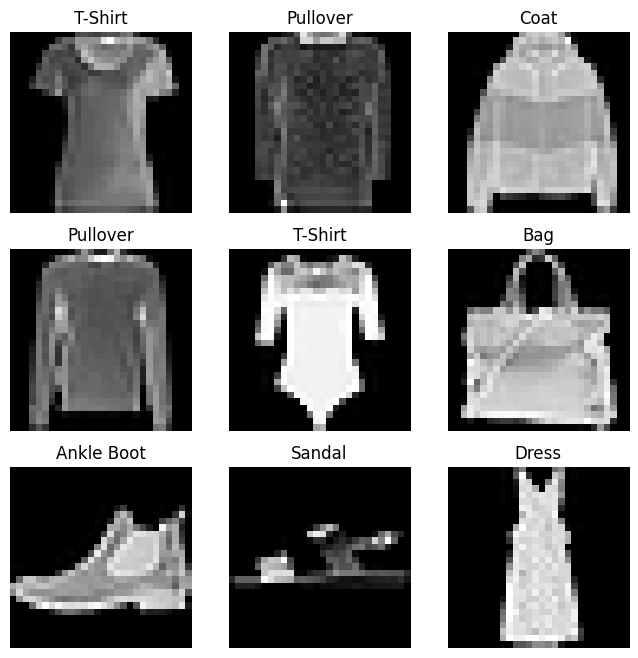

In [4]:
# Mappiamo gli indici delle classi alle relative etichette testuali.
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Creiamo una nuova figura di dimensioni 8x8 pollici.
figure = plt.figure(figsize=(8, 8))
# Definiamo il numero di colonne e righe per il layout dei subplot.
cols, rows = 3, 3
# Iteriamo attraverso i subplot della figura.
for i in range(1, cols * rows + 1):
    # Generiamo un indice casuale per estrarre un campione dal set di dati di addestramento.
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # Estraiamo l'immagine e l'etichetta corrispondente dal set di dati di addestramento.
    img, label = training_data[sample_idx]
    # Aggiungiamo un nuovo subplot alla figura.
    figure.add_subplot(rows, cols, i)
    # Impostiamo il titolo del subplot con l'etichetta corrispondente.
    plt.title(labels_map[label])
    # Disabilitiamo gli assi per una migliore visualizzazione.
    plt.axis("off")
    # Visualizziamo l'immagine come scala di grigi.
    plt.imshow(img.squeeze(), cmap="gray")

# Mostriamo la figura completa con i subplot.
plt.show()


# Reference
https://pytorch.org/tutorials/beginner/basics


# Author
Vetrano Alessio, 2024